In [65]:
with open("input.txt","r") as f:
    text = f.read()

In [66]:
text[:1000]

"First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we become rakes: for the gods know I\nspeak this in hunger 

In [3]:
chars = sorted(set(list(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [4]:
stoi = { ch:i for i,ch in enumerate(chars) }
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda i: ''.join([itos[c] for c in i])

In [70]:
print(encode("test"))
decode([58, 43, 57, 58])

[58, 43, 57, 58]


'test'

In [71]:
import torch

In [7]:
data = torch.tensor(encode(text),dtype=torch.long)

In [72]:
print(data[:100])

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


In [73]:
# train test split
n = int(0.9*len(text))
train_data = data[:n]
val_data = data[n:]

In [77]:
block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [78]:
x = train_data[:block_size]
y = train_data[1:block_size+1]

In [79]:
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"Context: {context}, Target: {target}")

Context: tensor([18]), Target: 47
Context: tensor([18, 47]), Target: 56
Context: tensor([18, 47, 56]), Target: 57
Context: tensor([18, 47, 56, 57]), Target: 58
Context: tensor([18, 47, 56, 57, 58]), Target: 1
Context: tensor([18, 47, 56, 57, 58,  1]), Target: 15
Context: tensor([18, 47, 56, 57, 58,  1, 15]), Target: 47
Context: tensor([18, 47, 56, 57, 58,  1, 15, 47]), Target: 58


In [80]:
torch.manual_seed(1337)
batch_size = 4

# create a random batch
def get_batch(split):
    data = train_data if split == "train" else val_data
    idx = torch.randint(len(data) - block_size,(batch_size,))
    x = torch.stack( [data[i:i+block_size] for i in idx] )
    y = torch.stack( [data[i+1:i+block_size+1] for i in idx ] )
    return x,y

In [81]:
xb,yb = get_batch("train")

In [15]:
import torch.nn as nn
from torch.nn import functional as F

In [84]:
class BigramLanguageModel(nn.Module):
    def __init__(self,vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size,vocab_size)
    
    def forward(self,x,y=None):
        
        # B -> Batches
#         T -> Times / Block Size
#         C -> Characters / Vocab Size
#         x and y both are of dimensions (B,T)
        logits = self.token_embedding_table(x) # (B,T,C)
    
        # Cross entropy expects input in a 2D form (B*T,C)
        if y is None:
            loss = None
        else:
            B,T,C = logits.shape
            logits = logits.view(B*T,C)
            y = y.view(B*T)

            loss = F.cross_entropy(logits,y)
    
        return logits, loss
    
    def generate(self,x,max_tokens):
        
        for _ in range(max_tokens):
            logits,loss = self(x)
            
            # keep logits for each batch
            logits = logits[:,-1,:] # B,T,C -> B,C
            
            # convert logits to a probability distribution
            # Dimesion: BxC
            probs = F.softmax( logits,dim=-1 ) # Apply softmax to the last dimension
#             print(probs)
            
            # Dimesnion: 1xB
            next_idx = torch.multinomial(probs,num_samples=1) # get 1 value with maximum probability
#             print(next_idx)
            x = torch.cat( (x,next_idx),dim=1 ) # Add to the next character: (B,T) -> (B,T+1)
        
        return x

In [85]:
m = BigramLanguageModel(vocab_size)
logits, loss = m(xb,yb)

In [92]:
print(decode(m.generate(xb,30)[0].tolist()))

Let's hesFSYxJui'-T'PU3v3fIKiuVQuIpn;.


In [93]:
optimizer = torch.optim.AdamW(m.parameters(),lr=1e-3)

In [97]:
batch_size = 32

for step in range(1000):
    xb,yb = get_batch("train")
    logits,loss = m(xb,yb)
#     optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(loss.item())

2.578108787536621


In [98]:
print(decode(m.generate(xb,300)[10].tolist()))

t, what!
WhetororeenethThido g sLouroonthePane stsessefollllleBin xetTENCrveaive burl senowhe wo on abr,
TELISe igr.JUDU a
Hirororeror dy heche,
Wheathice yeltheZARDOHak d$-t owoweay heDUCI orars. apstindohir wanay hyot ay ng,lRDI hntpld pyoom heiswh omerg acatea bt tayow wh comantifBor mile yo,XEE: o d tw,


In [22]:
# Self attention trick
# Take average of all tokens preceeding current position (This is a lossy representation of previous representation,
# however for now will be using it to build a rough base)

In [23]:
torch.manual_seed(1337)
B,T,C = 4,8,2
x = torch.randn((B,T,C))

In [24]:
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        tmp = x[b,:t+1] # get all tokens up till t
        xbow[b,t] = torch.mean(tmp,0) # to take a mean over dimension 0 (column)

In [25]:
# Self attention maths trick
wei = torch.tril( torch.ones(T,T) )
wei = wei / wei.sum(1,keepdim=True)
xbow2 = wei @ x # (T,T) @ (B,T,C) --> Torch treats this as a batch multiplication with each batch
# So each batch goes through the following mult (T,T) @ (T,C) --> (T,C) but averaged out
torch.allclose(xbow2,xbow)

True

In [26]:
# Version 3: Softmax
tril = torch.tril(torch.ones(T,T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float("-inf"))
wei = F.softmax(wei,dim=-1)
xbow3 = wei @ x
torch.allclose(xbow2,xbow3)

True

In [27]:
# Let's have each token emit 2 vectors --> Key,Query
# Key is what the token holds
# Query is what the token is looking for
# To get a better representation of previous data in the context of the current token we dot product the
# query vector with the keys of all previous tokens and get their affinities

# Value vector holds the aggregated value information for the current head
n_embd = 64

In [28]:
# Example
head_size = 16
# These linear layers project C dimension to a head_size dimesion
key = nn.Linear( C,head_size,bias=False )
query = nn.Linear( C,head_size,bias=False )
value = nn.Linear(C,head_size,bias=False)
k = key(x) # (B,T,C) --> (B,T,16)
q = query(x) # (B,T,C) --> (B,T,16)
v = value(x) # (B,T,C) --> (B,T,16)

wei = q @ k.transpose(-2,-1) # (B,T,16) @ (B,16,T) --> (T,T)

tril = torch.tril( torch.ones(T,T) )
wei = wei.masked_fill( tril == 0, float("-inf") ) # Remove affinities from future tokens
wei = F.softmax(wei,dim=-1) # Softmax with new affinities from key and query vectors

# out = wei @ x
out = wei @ v
out.shape

torch.Size([4, 8, 16])

In [29]:
# Cross attention is used when you want to communicate information between different sources.
# In this case the queries would be produced by the source we want the information on and the keys
# and the values are produced from a different source where we want to extract the information from
# in context to the query source
# Eg. query(x), key(xt), value(xt) [Different sources]
# As opposed to self-attention, i.e. query(x), key(x), value(x) [Same sources]

# We use scaled dot product(z): 

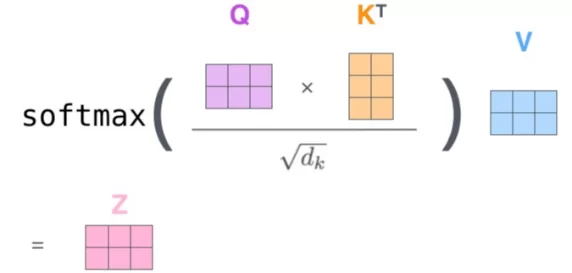

## We divide by the sqaure root of head of head size to preserve the variation of 1
Query and key both come from a unit gaussian distribution with variance 1, if we simply multiply the variance is not preserved.
This is a problem as as the variation becomes larger and larger, the softmax function starts producing skewed results which results in loss of information

In [30]:
class Head(nn.Module):
    def __init__(self,head_size):
        super().__init__()
        self.key = nn.Linear(n_embd,head_size,bias=False)
        self.query = nn.Linear(n_embd,head_size,bias=False)
        self.value = nn.Linear(n_embd,head_size,bias=False)
    
    def forward(self,x):
        # In this case we're taking head_size equal to C as passed in arguments
        # Hence, H = C
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        
        tril = torch.tril( torch.ones(T,T) ) # (T,T)
        # Scaled dot product
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B,T,H) @ (B,H,T) -> (B,T,T)
        wei = wei.masked_fill( tril == 0, float("-inf") )
        wei = F.softmax(wei,dim=-1)
        out = wei @ v # (B,T,T) @ (B,T,H) -> (B,T,H)
        return out
        

In [31]:
class BigramLanguageModel(nn.Module):
    def __init__(self,vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size,n_embd)
        
        # Dimensions: (T,C)
        self.positional_encoding_table = nn.Embedding(block_size,n_embd) # Each row represents the position and column which token
        self.sa_head = Head(n_embd) # Self attention head
        self.lm_head = nn.Linear(n_embd,vocab_size)

    def forward(self,x,y=None):
        
        # B -> Batches
#         T -> Times / Block Size
#         C -> Characters / Vocab Size
#         x and y both are of dimensions (B,T)

        B,T = x.shape
        token_embd = self.token_embedding_table(x) # (B,T) --> (B,T,C)
        posn_embd = self.positional_encoding_table(torch.arange(T)) # (T) --> (T,C)
        
        combined = token_embd + posn_embd
        combined = self.sa_head(combined)
        
        logits = self.lm_head(combined)
    
        # Cross entropy expects input in a 2D form (B*T,C)
        if y is None:
            loss = None
        else:
            B,T,C = logits.shape
            logits = logits.view(B*T,C)
            y = y.view(B*T)

            loss = F.cross_entropy(logits,y)
    
        return logits, loss
    
    def generate(self,x,max_tokens):
        
        for _ in range(max_tokens):
            idx_cond = x[:,-block_size:]
            
            logits,loss = self(idx_cond)
            
            # keep logits for each batch
            logits = logits[:,-1,:] # B,T,C -> B,C
            
            # convert logits to a probability distribution
            # Dimesion: BxC
            probs = F.softmax( logits,dim=-1 ) # Apply softmax to the last dimension
#             print(probs)
            
            # Dimesnion: 1xB
            next_idx = torch.multinomial(probs,num_samples=1) # get 1 value with maximum probability from each batch
#             print(next_idx)
            x = torch.cat( (x,next_idx),dim=1 ) # Add to the next character: (B,T) -> (B,T+1)
        
        return x

In [32]:
lr = 1e-3
n_embd = 64
m = BigramLanguageModel(vocab_size)
optimizer = torch.optim.AdamW(m.parameters(),lr=1e-6)

In [33]:
batch_size = 32

for step in range(30):
    xb,yb = get_batch("train")
    logits,loss = m(xb,yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if float(loss.item()) < 2.1 or float(loss.item()) > 10:
        print(loss.item())
        break

print(loss.item())

4.215722560882568


In [34]:
print(decode(m.generate(xb,300)[10].tolist()))

h live lr&gJPkQjIxB$xYCBSt&uGoWy&Se&hzrwqGulse:JmdQ;DXWVOiJb!MaxwsNk?H'?&sdfMBkOmknNEJ!kRS!DoUB3PGH.mYUycT3I!V.k,HmC
tkWf$lVVZWFGX,uNvHLSuGGCtCRgf.te!$aWpHw.fmFtfc-Hv&yuHPbUy$H'sF'!Kl;Q!';eHvPpr'W aNvpTJEAgv
vsWRQ'hV'F;!ZydExT!;k;ePZMq&PMLAmNrVoMt;pA!?NjiXDTuJXXKGYhUkIPInxjFNuXSD 
yCvifcsdM''V:;3ck?ohIvmgNX


# Multi-head attention

- Multiple self attention heaads running in parallel and the concatenated together
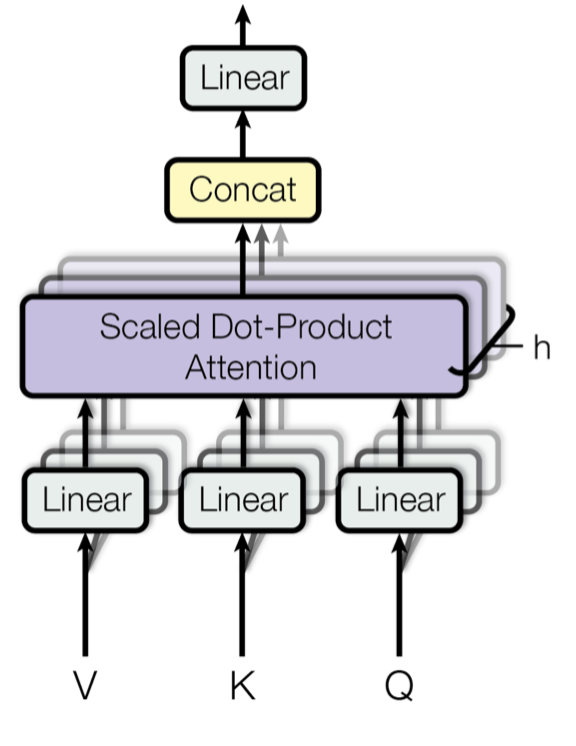

- Helps to create multiple independent channels of communication
- Each head can focus on a different asepct of the input for and find relations to communicate

In [35]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self,num_heads,head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
    
    def forward(self,x):
#         print("running")
        return torch.cat( [h(x) for h in self.heads], dim=-1 )

In [36]:
class BigramLanguageModel(nn.Module):
    def __init__(self,vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size,n_embd)
        
        # Dimensions: (T,C)
        self.positional_encoding_table = nn.Embedding(block_size,n_embd) # Each row represents the position and column which token
        self.sa_head = MultiHeadSelfAttention(4,n_embd//4) # Multi-Head Self attention head
        self.lm_head = nn.Linear(n_embd,vocab_size)

    def forward(self,x,y=None):
        
        # B -> Batches
#         T -> Times / Block Size
#         C -> Characters / Vocab Size
#         x and y both are of dimensions (B,T)

        B,T = x.shape
        token_embd = self.token_embedding_table(x) # (B,T) --> (B,T,C)
        posn_embd = self.positional_encoding_table(torch.arange(T)) # (T) --> (T,C)
        
        combined = token_embd + posn_embd
        combined = self.sa_head(combined)
        
        logits = self.lm_head(combined)
    
        # Cross entropy expects input in a 2D form (B*T,C)
        if y is None:
            loss = None
        else:
            B,T,C = logits.shape
            logits = logits.view(B*T,C)
            y = y.view(B*T)

            loss = F.cross_entropy(logits,y)
    
        return logits, loss
    
    def generate(self,x,max_tokens):
        
        for _ in range(max_tokens):
            idx_cond = x[:,-block_size:]
            
            logits,loss = self(idx_cond)
            
            # keep logits for each batch
            logits = logits[:,-1,:] # B,T,C -> B,C
            
            # convert logits to a probability distribution
            # Dimesion: BxC
            probs = F.softmax( logits,dim=-1 ) # Apply softmax to the last dimension
#             print(probs)
            
            # Dimesnion: 1xB
            next_idx = torch.multinomial(probs,num_samples=1) # get 1 value with maximum probability from each batch
#             print(next_idx)
            x = torch.cat( (x,next_idx),dim=1 ) # Add to the next character: (B,T) -> (B,T+1)
        
        return x

In [37]:
lr = 1e-3
n_embd = 64
m = BigramLanguageModel(vocab_size)
optimizer = torch.optim.AdamW(m.parameters(),lr=1e-6)

In [38]:
batch_size = 32

for step in range(300):
    xb,yb = get_batch("train")
    logits,loss = m(xb,yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if float(loss.item()) < 2.3 or float(loss.item()) > 10:
        print(loss.item())
        break

print(loss.item())
print(decode(m.generate(xb,300)[10].tolist()))

4.116871356964111
 walls anA'GkY-ttyljrUtSu$rLlG!Pes3fTwIZnTDsgwEPYtB'pH,e&dK?VoUiekrc.Yhbs? AKb:$ EzBMPzUyabycpMPHBDVvUzF,avc!VpHOPhXJz-sRH:y
ycWq?rpn'p.O:s bhBaqnXCgdo:h$!.tdKlyXgR:ApHd,PwwtnGckH?bM$g
ftULQBp'QOpuOiOl P?T
H
o $AVJTPOlgUsCtqQ$cAyJCIlMeQHz
dV-!T;:.BBsfTYjlYGFV;P&:eSl&,VI:::xjov Xa'm,rywyA;GBUu3PqKcucIN3ZPp!n


# Feed-Forward Mechanism 
- Till now we have enabled the neural network to communicate with previous tokens and find useful relations
- We will now integrate the layer where neural network will be able to perform calculations and generate meaningful tokens
- Till now the tokens were able to look at each other but they weren't able to think on those relations and make meaningful calculation
- This is applied on each token individually

In [39]:
class FeedForward(nn.Module):
    def __init__(self,n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd,n_embd),
            nn.ReLU()
        )
    
    def forward(self,x):
        return self.net(x)

In [40]:
class BigramLanguageModel(nn.Module):
    def __init__(self,vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size,n_embd)
        
        # Dimensions: (T,C)
        self.positional_encoding_table = nn.Embedding(block_size,n_embd) # Each row represents the position and column which token
        self.sa_head = MultiHeadSelfAttention(4,n_embd//4) # Multi-Head Self attention head
        self.ffw = FeedForward(n_embd)
        self.lm_head = nn.Linear(n_embd,vocab_size)

    def forward(self,x,y=None):
        
        # B -> Batches
#         T -> Times / Block Size
#         C -> Characters / Vocab Size
#         x and y both are of dimensions (B,T)

        B,T = x.shape
        token_embd = self.token_embedding_table(x) # (B,T) --> (B,T,C)
        posn_embd = self.positional_encoding_table(torch.arange(T)) # (T) --> (T,C)
        
        combined = token_embd + posn_embd # (B,T,C)
        combined = self.sa_head(combined) # (B,T,H) [H=Head Size, in this case H=C]
        
        ffw = self.ffw(combined) # (B,T,C)
        
        logits = self.lm_head(ffw)
    
        # Cross entropy expects input in a 2D form (B*T,C)
        if y is None:
            loss = None
        else:
            B,T,C = logits.shape
            logits = logits.view(B*T,C)
            y = y.view(B*T)

            loss = F.cross_entropy(logits,y)
    
        return logits, loss
    
    def generate(self,x,max_tokens):
        
        for _ in range(max_tokens):
            idx_cond = x[:,-block_size:]
            
            logits,loss = self(idx_cond)
            
            # keep logits for each batch
            logits = logits[:,-1,:] # B,T,C -> B,C
            
            # convert logits to a probability distribution
            # Dimesion: BxC
            probs = F.softmax( logits,dim=-1 ) # Apply softmax to the last dimension
#             print(probs)
            
            # Dimesnion: 1xB
            next_idx = torch.multinomial(probs,num_samples=1) # get 1 value with maximum probability from each batch
#             print(next_idx)
            x = torch.cat( (x,next_idx),dim=1 ) # Add to the next character: (B,T) -> (B,T+1)
        
        return x

In [41]:
lr = 1e-3
n_embd = 64
m = BigramLanguageModel(vocab_size)
optimizer = torch.optim.AdamW(m.parameters(),lr=1e-3)

In [42]:
batch_size = 32

for step in range(300):
    xb,yb = get_batch("train")
    logits,loss = m(xb,yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
#     if float(loss.item()) < 2.3 or float(loss.item()) > 10:
#         print(loss.item())
#         break

print(loss.item())
print(decode(m.generate(xb,300)[10].tolist()))

2.6030986309051514
.

JOHN YEUIRILKNOrLYe'n:
Gre owin houd cero'n f-covatseriow ron'fukurs thad,
FHeiet Blyuu wun a
E macep bint ed cent,
He Lhaey harcank
Ar
A:
N
NMMx pyd
Towo id: gumaelr:
Tr Ehe,
BT,,
Ldgartird agy deur pelas ngo
BFcomarg thard -d: the that Bhancey orich de
BI
AHrafelag hwas ho idap ton yanda
ut thath hA da


# Constructing the final Decoder Block

In [43]:
class Block(nn.Module):
    def __init__(self,n_embd,n_heads):
        super().__init__()
        head_size = n_embd // n_heads
        self.sa = MultiHeadSelfAttention(n_heads,head_size)
        self.ffw = FeedForward(n_embd)
    
    def forward(self,x):
        x = self.sa(x)
        x = self.ffw(x)
        return x

In [44]:
class BigramLanguageModel(nn.Module):
    def __init__(self,vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size,n_embd)
        
        # Dimensions: (T,C)
        self.positional_encoding_table = nn.Embedding(block_size,n_embd) # Each row represents the position and column which token
#         self.sa_head = MultiHeadSelfAttention(4,n_embd//4) # Multi-Head Self attention head
#         self.ffw = FeedForward(n_embd)
        self.blocks = nn.Sequential(
            Block(n_embd,n_heads=4),
            Block(n_embd,n_heads=4),
            Block(n_embd,n_heads=4),
        )
        self.lm_head = nn.Linear(n_embd,vocab_size)

    def forward(self,x,y=None):
        
        # B -> Batches
#         T -> Times / Block Size
#         C -> Characters / Vocab Size
#         x and y both are of dimensions (B,T)

        B,T = x.shape
        token_embd = self.token_embedding_table(x) # (B,T) --> (B,T,C)
        posn_embd = self.positional_encoding_table(torch.arange(T)) # (T) --> (T,C)
        
        combined = token_embd + posn_embd # (B,T,C)
#         combined = self.sa_head(combined) # (B,T,H) [H=Head Size, in this case H=C]
#         ffw = self.ffw(combined) # (B,T,C)

        x = self.blocks(combined)
        
        logits = self.lm_head(x)
    
        # Cross entropy expects input in a 2D form (B*T,C)
        if y is None:
            loss = None
        else:
            B,T,C = logits.shape
            logits = logits.view(B*T,C)
            y = y.view(B*T)

            loss = F.cross_entropy(logits,y)
    
        return logits, loss
    
    def generate(self,x,max_tokens):
        
        for _ in range(max_tokens):
            idx_cond = x[:,-block_size:]
            
            logits,loss = self(idx_cond)
            
            # keep logits for each batch
            logits = logits[:,-1,:] # B,T,C -> B,C
            
            # convert logits to a probability distribution
            # Dimesion: BxC
            probs = F.softmax( logits,dim=-1 ) # Apply softmax to the last dimension
#             print(probs)
            
            # Dimesnion: 1xB
            next_idx = torch.multinomial(probs,num_samples=1) # get 1 value with maximum probability from each batch
#             print(next_idx)
            x = torch.cat( (x,next_idx),dim=1 ) # Add to the next character: (B,T) -> (B,T+1)
        
        return x

# Residual Connections
- These are residual connections of the input to a layer directly to the output of the computed layer through a simple addition block
- This dramatically helps in optimization as during back propogation the gradient is able to freely flow through the addition nodes without any other computational nodes
- This in a sense creates a super-highway directly from the output to the input, the nodes in the other forked branch of the layer eventually come online over time and kick in

# Transformer Architecture

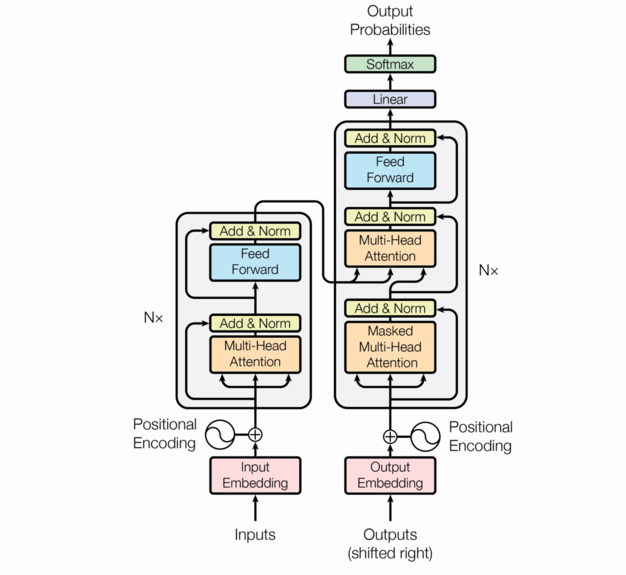

- Here we can see at each layer of the decoder block there is a residual connection to the addition and normalization block


In [45]:
class Block(nn.Module):
    def __init__(self,n_embd,n_heads):
        super().__init__()
        head_size = n_embd // n_heads
        self.sa = MultiHeadSelfAttention(n_heads,head_size)
        self.ffw = FeedForward(n_embd)
    
    def forward(self,x):
        x = x + self.sa(x) # Adding a branch off addition
        x = x + self.ffw(x) # Adding a branch off addition
        return x

In [46]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self,num_heads,head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        # Doubt here
        self.proj = nn.Linear(n_embd,n_embd) # Why add a linear projection for a residual addition connection
    
    def forward(self,x):
        out = torch.cat( [h(x) for h in self.heads], dim=-1 )
        return self.proj(x)

# Adding a multiplier
- We roll out the layer to more nodes to give it more computational space
- A multiplier of 4 was used in the original transformer paper

In [47]:
class FeedForward(nn.Module):
    def __init__(self,n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd,4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd,n_embd) # Added for residual connection
        )
    
    def forward(self,x):
        return self.net(x)

In [48]:
lr = 1e-3
n_embd = 64
m = BigramLanguageModel(vocab_size)
optimizer = torch.optim.AdamW(m.parameters(),lr=1e-4)

In [49]:
batch_size = 32

for step in range(300):
    xb,yb = get_batch("train")
    logits,loss = m(xb,yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
#     if float(loss.item()) < 2.3 or float(loss.item()) > 10:
#         print(loss.item())
#         break

print(loss.item())
print(decode(m.generate(xb,20)[10].tolist()))

2.797549247741699
or, as stfc. mbRmandee
ncorc


# Layer Normalization
- We add layer normalization to optimise the neural network further for handling smaller batch sizes and make it more generalised to inputs
- In the original transformer design the layer normalization happened after each layer, however it is important to note that over the years it has proven better to use normaliztion before each layer operation
- It normalizes eacah feature and make it a unit gaussian distribution

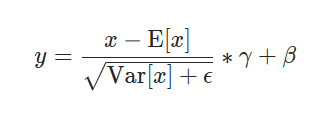

- Here gamma and alpha are trainable parameters
- x is the LAYER input and y is the normalized output

In [50]:
class Block(nn.Module):
    def __init__(self,n_embd,n_heads):
        super().__init__()
        head_size = n_embd // n_heads
        self.sa = MultiHeadSelfAttention(n_heads,head_size)
        self.ffw = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
    
    def forward(self,x):
        x = x + self.sa(self.ln1(x)) # Adding a branch off addition
        x = x + self.ffw(self.ln2(x)) # Adding a branch off addition
        return x

In [51]:
class BigramLanguageModel(nn.Module):
    def __init__(self,vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size,n_embd)
        
        # Dimensions: (T,C)
        self.positional_encoding_table = nn.Embedding(block_size,n_embd) # Each row represents the position and column which token
#         self.sa_head = MultiHeadSelfAttention(4,n_embd//4) # Multi-Head Self attention head
#         self.ffw = FeedForward(n_embd)
        self.blocks = nn.Sequential(
            Block(n_embd,n_heads=4),
            Block(n_embd,n_heads=4),
            Block(n_embd,n_heads=4),
            nn.LayerNorm(n_embd)
        )
        self.lm_head = nn.Linear(n_embd,vocab_size)

    def forward(self,x,y=None):
        
        # B -> Batches
#         T -> Times / Block Size
#         C -> Characters / Vocab Size
#         x and y both are of dimensions (B,T)

        B,T = x.shape
        token_embd = self.token_embedding_table(x) # (B,T) --> (B,T,C)
        posn_embd = self.positional_encoding_table(torch.arange(T)) # (T) --> (T,C)
        
        combined = token_embd + posn_embd # (B,T,C)
#         combined = self.sa_head(combined) # (B,T,H) [H=Head Size, in this case H=C]
#         ffw = self.ffw(combined) # (B,T,C)

        x = self.blocks(combined)
        
        logits = self.lm_head(x)
    
        # Cross entropy expects input in a 2D form (B*T,C)
        if y is None:
            loss = None
        else:
            B,T,C = logits.shape
            logits = logits.view(B*T,C)
            y = y.view(B*T)

            loss = F.cross_entropy(logits,y)
    
        return logits, loss
    
    def generate(self,x,max_tokens):
        
        for _ in range(max_tokens):
            idx_cond = x[:,-block_size:]
            
            logits,loss = self(idx_cond)
            
            # keep logits for each batch
            logits = logits[:,-1,:] # B,T,C -> B,C
            
            # convert logits to a probability distribution
            # Dimesion: BxC
            probs = F.softmax( logits,dim=-1 ) # Apply softmax to the last dimension
#             print(probs)
            
            # Dimesnion: 1xB
            next_idx = torch.multinomial(probs,num_samples=1) # get 1 value with maximum probability from each batch
#             print(next_idx)
            x = torch.cat( (x,next_idx),dim=1 ) # Add to the next character: (B,T) -> (B,T+1)
        
        return x

In [52]:
lr = 1e-3
n_embd = 64
m = BigramLanguageModel(vocab_size)
optimizer = torch.optim.AdamW(m.parameters(),lr=1e-4)

In [53]:
batch_size = 32
block_size = 8

for step in range(30000):
    xb,yb = get_batch("train")
    logits,loss = m(xb,yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if float(loss.item()) < 2 or float(loss.item()) > 10:
        print(loss.item())
        break

print(loss.item())
print(decode(m.generate(xb,20)[10].tolist()))

KeyboardInterrupt: 

In [54]:
print(decode(m.generate(xb,200)[10].tolist()))

and in pXore tr theaweBI ce pred nd id ve m h y po tet.
Uout pofdoonofnshandasay hesn fou d,
-OCilemellll d :
LKELalle thou me ag Ch h.
O
Al
DYorfonoin ieayor'. d

Muratllyous hpresese hivis weTV t aly; an f 


In [55]:
sum(p.numel() for p in m.parameters())/1e6

0.158401

# Fine-Tuning
- So far we have worked on the 1st of the 2 phases in chatGPT that is the pre-training phase
- The current model is trained to complete a document or finish a sentence and generate further
- If you ask it a question if will probably give you more similar question or try to complete it
- To train it like an assistant fine-tuning is required
- It is much harder to fine tune as it requires manual data creation and an independent RL model using PPO to rate the outputs of the model

In [56]:
vocab_size

65

In [57]:
print(decode(m.generate(xb,200)[5].tolist()))

maculatea e ilere bndove orch.omathoathIfthecoulou chand th tht ld orreriofocecighellillermogh s to llli?
GEANGouce fir s;

Hav:
F 'semeld avein ge

Tun Ashy toforand wouse llserere.

TKLAAnderoigr d domy.
We


In [58]:
print(decode(yb[5].tolist()))

aculate 


In [61]:
len(encode("#include<stdio.h>int main(){printf(\"Hellow daaddy\");return 0;"))

61

In [60]:
stoi["#"] = 1000
stoi["<"] = 1001
stoi[">"] = 1002
stoi["("] = 1003
stoi[")"] = 1004
stoi["\\"] = 1005
stoi["{"] = 1006
stoi["}"] = 1007
stoi["\""] = 1008
stoi["0"] = 1009

In [ ]:
stoi.keys()

In [ ]:
len([2, 17256, 27, 19282, 952, 13, 71, 29, 198, 198, 600, 1388, 39893, 198, 37435, 7203, 39, 5037, 12379, 13218, 15341, 198, 198, 7783, 657, 26, 198, 92, 628])

In [ ]:
yb

In [ ]:
xb